## Correlation Power Analysis - Key Recovery


In this part of the project, you will use the traces you collected in the first part of the project to complete the steps of the CPA attack and recover the key.

## Steps 3-4 Calculating Hypothetical Power

We attack our AES design during the first round at the output of the register FF1 (see the figure below). The equation for calculating the Hamming Distance (HD) is shown in the eqation below. We use HD model since it is suitable for CMOS technology and we know the the value of the intermediate at the attack point on two consecutive clock cycles.

![AES Block Diagram](figures/aes128.png "AES Block Diagram")

The formula to calculated the hypothetical power is:

H(i,j) = HD(SBOX(CT(i) ), SBOX(kguess(j) xor PT(i+1) ))



### Excercise:
Run the following cell to load the libraries needed.

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import fobos.traceset as traceset 
import fobos.cpa as cpa
import fobos.projmgr as projmgr
import fobos.powermodels.AESFirstLast as powermodel #code to calculate hypothetical power
import fobos.powermodels.utils as powermodelUtils
plt.rcParams.update({'font.size': 18})

In the folowing cell, specify the directory where the captured traces are stored.
The location is likely in the form attampt-ii (e.g. attempt-01)



In [11]:
# Configure project directories ################################
ATTEMPT_DIR = "attempt-25" # the location is likely in the form attampt-i (e.g. attempt-1)
WORKSPACE = "fobosworkspace/aes/capture"
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(ATTEMPT_DIR)
projDir = pm.getProjDir()
analysisDir = pm.getAnalysisDir()

Successfully created new capture directory at fobosworkspace/aes/capture/attempt-25/analysis/attempt-40


In [12]:
configFile = open(os.path.join(projDir, 'acquisitionConfig.json'))
acqConf = json.load(configFile)
print(f'Acquisition config = {acqConf}')
######
TRACES_FILE = os.path.join(projDir, acqConf['traceFile'])
PLAIN_FILE = os.path.join(projDir, acqConf['plainFile'])
CIPHER_FILE = os.path.join(projDir, acqConf['cipherFile'])
HYPO_FILE = os.path.join(projDir, "hypotheticalPower.npy")

Acquisition config = {'ip': '192.168.10.99', 'port': 9995, 'workspace': 'fobosworkspace', 'projectName': 'aes', 'plainFile': 'plaintext.txt', 'dinFile': 'dinFile.txt', 'bitFile': 'half_duplex_dut.bit', 'cipherFile': 'ciphertext.txt', 'traceFile': 'powerTraces.npy', 'traceNum': 10000, 'DUTClk': 1, 'samplingFreq': 50, 'samplesPerTrace': 1000, 'ADCGain': 50, 'outLen': 16}


Note the directory above. All output files will be stored  in here.

After we set the directories and specify input files, we set **capConf['cropStart']** and **cpaConf['cropEnd']** which selects the range of samples to be considered for the attack. Only that range will be used to speedup calculation.

The attack targets an intermediate value calculated at the first clock cycle of AES encryption.

***Can we plot the first 100 traces here again?***

1 - Looking at the trace you collected in the previous part, what is the range of samples for the first clock cycle (Hint: AES starts after loading data)?

In [13]:
cpaConf = {}
cpaConf['cropStart'] = 200
cpaConf['cropEnd'] = 250
cpaConf['traceNum'] = acqConf['traceNum']
#cpaConf['traceNum'] = 4000  # override acquisiton_config parameter here
# save config file
cpaConfFile = open(os.path.join(analysisDir, 'cpaConfig.json'), 'w')
cpaConfFile.write(json.dumps(cpaConf, indent=4))
cpaConfFile.close()

Now, lets load the traces by runnuing the following cell.

Loading raw traces from file: fobosworkspace/aes/capture/attempt-25/powerTraces.npy
Please wait ...
DEBUG: Module: analysis, Function: detectSampleSize():
----Detecting samples per trace
----It looks that the max number of samples in the first 10 traces is: 1008
Loading done.
[[525. 536. 528. ... 372. 333. 309.]
 [482. 486. 490. ... 515. 477. 454.]
 [502. 503. 500. ... 515. 479. 440.]
 ...
 [461. 468. 469. ... 536. 503. 456.]
 [481. 488. 481. ... 517. 488. 460.]
 [430. 426. 424. ... 543. 497. 464.]]
The shape of the traces matrix is (10000, 50)


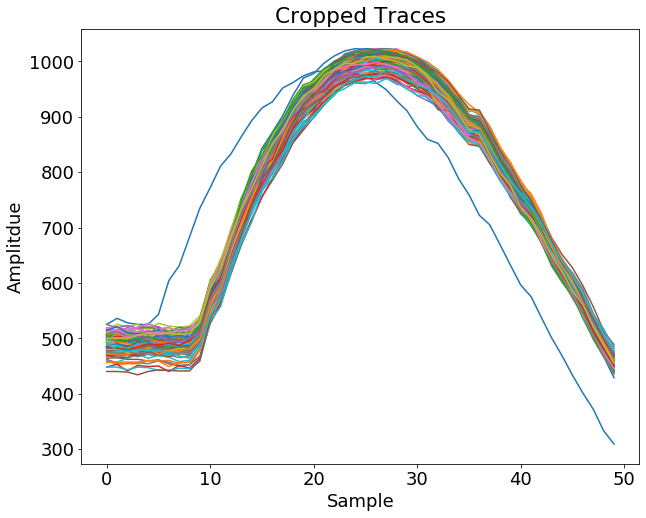

In [16]:
# load traces from file.
traceSet = traceset.TraceSet(traceNum=cpaConf['traceNum'],
                            fileName=TRACES_FILE,
                            cropStart=cpaConf['cropStart'],
                            cropEnd=cpaConf['cropEnd'])

measuredPower = traceSet.traces
print(f'The shape of the traces matrix is {measuredPower.shape}')


maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Cropped Traces')
for i in range(min(maxtrace, acqConf['traceNum'])):
    plt.plot(measuredPower[i])


2- What is stored in the rows of the measuredPower matrix? Why it has these number of rows and columns? What do they represent?

Run the following cell to calculate the hypothetical power matrix. This uses the plaintext and ciphertext in the calculation as shown in the formula below.

H(i,j) = HD(SBOX(CT(i) ), SBOX(kguess(j) xor PT(i+1) ))

Please noted that this is applied one byte at a time.

In [17]:
if os.path.isfile(HYPO_FILE):
    hypotheticalPower = powermodelUtils.loadHypoPower(HYPO_FILE)
else:
    hypotheticalPower = powermodel.getHypotheticalPower(PLAIN_FILE,
                                                    CIPHER_FILE,
                                                    acqConf['traceNum'])
    powermodelUtils.saveHypoPower(hypotheticalPower, HYPO_FILE)

Loading hypothetical power from fobosworkspace/aes/capture/attempt-25/hypotheticalPower.npy
loading done.


3- What is stored in the rows of the hypotheticalPower matrix? Why does it have these number of rows and columns? What do they represent?



Run the following cell to run the attack. It will take few minutes to finish. This will use the hypothetical power matrix (for eack key byte) and the traces collected from the hardware.

In [18]:
# Perform the attack
numKeys = 16 # number of subkeys to attack
cpaAttacker = cpa.CPA()
C = cpaAttacker.doCPA(measuredPower=measuredPower,
                      hypotheticalPower=hypotheticalPower,
                      numTraces=cpaConf['traceNum'],
                      analysisDir=analysisDir,
                      MTDStride= 100,
                      numKeys = numKeys
                      )

(10000, 50)
subkey number = 0, subkey value = 0x1, correlation = 0.07912917031047192, at sample = 25
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 1, subkey value = 0x23, correlation = 0.10486291974059507, at sample = 29
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 2, subkey value = 0x45, correlation = 0.11027366523790563, at sample = 27
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 3, subkey value = 0x67, correlation = 0.09747235569878573, at sample = 29
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 4, subkey value = 0x89, correlation = 0.0831607514592139, at sample = 31
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 5, subkey value = 0xab, correlation = 0.08466749976319404, at sample = 28
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 6, subkey value = 0xcd, correlation = 0.08645326716220153, at sample = 30
    plotting correlation

4- What is the key that is found? Verify its correctness with any online AES calculator. Is it the correct key?


Click on File->Open and go to fobosworkspace/aes. Continue to browes to the analysis directory. You should find graphs generated by the CPA software. 

5- What are the two types of graphs you find? What is the purpoes of each of the two (include samples in your report)?

6- What is the minimum number of traces enough for full key recovery?

7- At which range of samples the you get the highst correclation (relative to the original trace. Remember the crop settings)

8- Why do we not get them all at the same sample.

9 - What is the range of MTD for the different key bytes.

10- Why do some key bytes require fewer measurements than others.